# FULLY CONNECTED NEURAL NETWORK FROM SCRATCH

We are going to build a fully connected deep neural network from scratch with an architecture like the image below

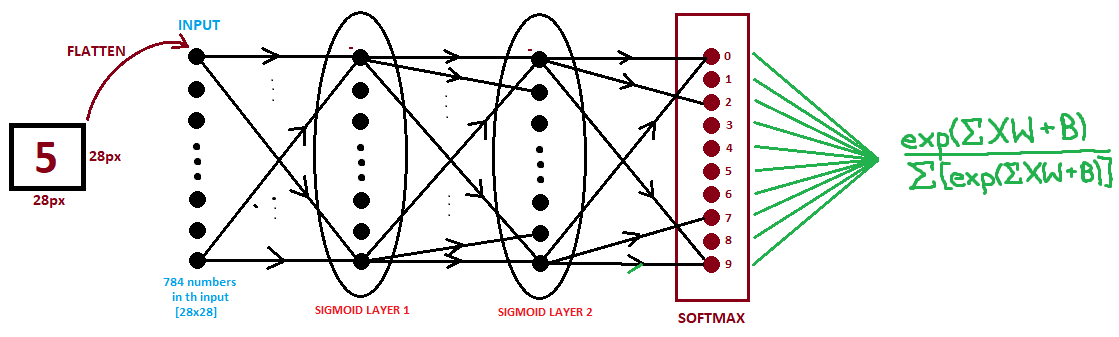

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

### Definition of the sigmoid function and its derivative

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

### Sigmoid layer definition

In [8]:
#Creating an object representing a layer, you must specify from how many inputs the layer is to read values
#(usually it is the number of outputs of the previous layer) and the number of neurons in the layer)
class Sigmoid:
  def __init__(self, number_of_input_nodes, number_of_neurons):
    self.weights = np.random.randn(number_of_input_nodes, number_of_neurons )
    self.biases = np.random.randn(1,number_of_neurons)
  
  def forward_prop(self, input_data):
    self.orig_input = input_data
    self.input_data = input_data #to be used in backprop
    
    self.XW_B = np.dot(self.input_data, self.weights) + self.biases
    self.output_val = sigmoid(self.XW_B)
    return self.output_val
  
  def back_prop(self, gradient, learning_rate):
    layer_activation_der = sigmoid_der(self.XW_B)
    
    dXWB__dinputs = self.weights.copy()
 
    dJ_dweights = self.input_data.T @ (gradient * layer_activation_der)
    dJ_dbiases =  np.sum((gradient * layer_activation_der),axis=0)
 
    self.weights -= learning_rate * dJ_dweights
    self.biases -= learning_rate * dJ_dbiases
 
    output_gradient = (gradient * layer_activation_der) @ dXWB__dinputs.T
 
    return output_gradient

### Softmax layer definition

In [11]:
#Definition of the last layer of the neural network to recognize the class of the image "inserted" into the input of the neural network e.g. dog or cat
#Layer has as many neurons as classes to be distributed
#Each neuron returns the probability that the object in the input belongs to the class represented by it

class Softmax:
  def __init__(self, input_node, softmax_node):
    self.weight = np.random.randn(input_node, softmax_node)/input_node
    self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):
    self.orig_im_shape = image.shape #used in backprop
    image_modified = image.flatten()
    self.modified_input = image_modified #to be used in backprop
    output_val = np.dot(image_modified, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out/np.sum(exp_out, axis=0)

  def back_prop(self, dL_dout, learning_rate):
    for i, grad in enumerate(dL_dout):
      if grad ==0:
        continue

      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      #gradients with respect to out (z)
      dy_dz = -transformation_eq[i]*transformation_eq / (S_total **2)
      dy_dz[i] = transformation_eq[i]*(S_total -  transformation_eq[i]) / (S_total **2)

      #gradients of totals against weights/biases/input
      dz_dw =  self.modified_input
      dz_db = 1
      dz_d_inp = self.weight

      #gradients of loss against totals
      dL_dz = grad * dy_dz

      #gradients of loss against weights/biases/input
      dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_db
      dL_d_inp = dz_d_inp @ dL_dz

    self.weight -= learning_rate *dL_dw
    self.bias -= learning_rate * dL_db

    return dL_d_inp.reshape(self.orig_im_shape)

### MSE cost function and its derivative

In [12]:
def MeanSquare_Error(y_hat, y):
  mse = 1/y_hat.shape[0]*np.sum((y_hat-y)**2)
  return mse
 
def MSE_der(y_hat, y):
  mse_der = y_hat - y
  return mse_der

### Binary Cross Entropy cost function and its derivative

In [13]:
def Cross_Entropy(y_hat,y):
  return 1/y_hat.shape[0]*np.sum( -1*((y>0) * np.log(y_hat))-1*(y==0)* np.log(1-y_hat))
 
def derivative_Cross_Entropy(y_hat,y):
  return -1*((y>0) / y_hat)+((y==0) / (1-y_hat))

### Downloading and splitting the dataset

In [14]:
# MNIST dataset is included in Keras
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train  = X_train.reshape(60000, 784)
X_test  = X_test.reshape(10000, 784)

#KROK 2- zmienic typ na float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (40200, 784)
y_train shape (40200,)
X_val shape (19800, 784)
y_val shape (19800,)
X_test shape (10000, 784)
y_test shape (10000,)


## Definition of neural network

In [15]:
SIGMOID_LAYER1 = Sigmoid(784, 128)
SIGMOID_LAYER2 = Sigmoid(128, 64)
SOFTMAX_LAYER = Softmax(64, 10)

In [16]:
train_images = X_train[:1500]
train_labels = y_train[:1500]

val_images = X_val[:1500]
val_labels = y_val[:1500]

test_images = X_test[:1500]
test_labels = y_test[:1500]

In [17]:
def nn_forward_prop(image, label):
  out_p = SIGMOID_LAYER1.forward_prop(image)
  out_p = SIGMOID_LAYER2.forward_prop(out_p)
  out_p = SOFTMAX_LAYER.forward_prop(out_p)

  cross_ent_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_ent_loss, accuracy_eval

def training_nn(image, label, learn_rate =0.005):
  out, loss, acc = nn_forward_prop(image, label)

  #calculate ininital gradient
  gradient = np.zeros(10)
  #pochodna z funkcji kosztu cross-entropy
  #out[label] - odpowiedz neuronu ktory mial rozpoznac cyferke
  gradient[label] = -1 / out[label]

  #BACKPROP
  grad_back = SOFTMAX_LAYER.back_prop(gradient, learn_rate)
  grad_back = SIGMOID_LAYER2.back_prop(grad_back, learn_rate)
  grad_back = SIGMOID_LAYER1.back_prop(grad_back, learn_rate)

  return loss, acc

In [18]:
def train_and_evaluate(train_images, train_labels, val_images, val_labels, epochs=10, learning_rate=0.005):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        print('Epoch %d ->' % (epoch + 1))
        shuffle_data = np.random.permutation(len(train_images))
        train_images = train_images[shuffle_data]
        train_labels = train_labels[shuffle_data]

        loss = 0.0
        num_correct = 0

        for i, (im, label) in enumerate(zip(train_images, train_labels)):
            im = im.reshape(1, 784)
            l1, accu = training_nn(im, label, learning_rate)
            loss += l1
            num_correct += accu

            if i % 100 == 0 and i > 0:
                print('%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%' % (i, loss / 100, num_correct))
                loss = 0
                num_correct = 0

        train_loss_history.append(loss / len(train_images))
        train_acc_history.append(num_correct / len(train_images) * 100)

        val_loss = 0
        val_num_correct = 0

        for im, label in zip(val_images, val_labels):
            im = im.reshape(1, 784)
            _, l1, accu = nn_forward_prop(im, label)
            val_loss += l1
            val_num_correct += accu

        val_loss_history.append(val_loss / len(val_images))
        val_acc_history.append(val_num_correct / len(val_images) * 100)

        print('Validation Loss: %.3f and Validation Accuracy: %d%%' % (val_loss / len(val_images), val_num_correct / len(val_images) * 100))

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

## Train and evaluate the model

In [19]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_and_evaluate(train_images, train_labels, val_images, val_labels, epochs=10, learning_rate=0.005)

Epoch 1 ->
100 steps out of 100 steps: Average Loss 2.321 and Accuracy: 12%
200 steps out of 100 steps: Average Loss 2.313 and Accuracy: 11%
300 steps out of 100 steps: Average Loss 2.258 and Accuracy: 20%
400 steps out of 100 steps: Average Loss 2.229 and Accuracy: 21%
500 steps out of 100 steps: Average Loss 2.215 and Accuracy: 19%
600 steps out of 100 steps: Average Loss 2.183 and Accuracy: 30%
700 steps out of 100 steps: Average Loss 2.135 and Accuracy: 23%
800 steps out of 100 steps: Average Loss 2.116 and Accuracy: 29%
900 steps out of 100 steps: Average Loss 2.103 and Accuracy: 34%
1000 steps out of 100 steps: Average Loss 2.079 and Accuracy: 29%
1100 steps out of 100 steps: Average Loss 2.048 and Accuracy: 35%
1200 steps out of 100 steps: Average Loss 1.987 and Accuracy: 42%
1300 steps out of 100 steps: Average Loss 1.920 and Accuracy: 43%
1400 steps out of 100 steps: Average Loss 1.959 and Accuracy: 36%
Validation Loss: 1.961 and Validation Accuracy: 42%
Epoch 2 ->
100 steps o

### Plot training and validation accuracy

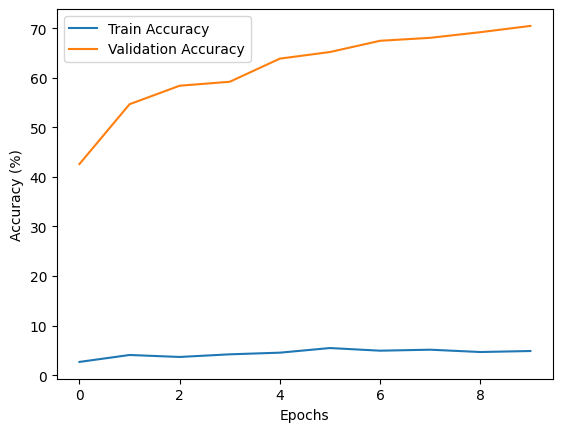

In [20]:
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot training and validation loss

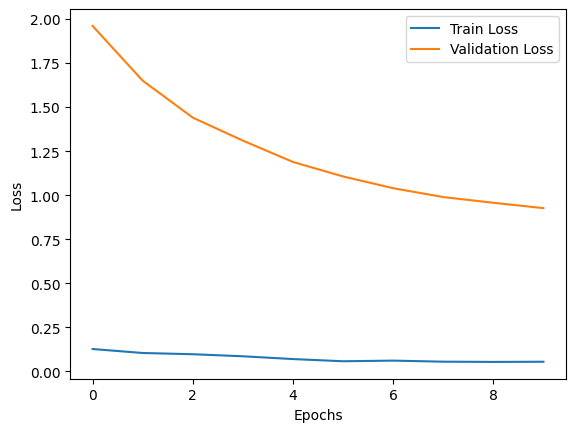

In [21]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing neural network

In [22]:
def test_nn(test_images, test_labels):
    test_loss = 0
    test_num_correct = 0

    for im, label in zip(test_images, test_labels):
        im = im.reshape(1, 784)
        _, l1, accu = nn_forward_prop(im, label)
        test_loss += l1
        test_num_correct += accu

    test_loss /= len(test_images)
    test_accuracy = test_num_correct / len(test_images) * 100

    print('Test Loss: %.3f' % test_loss)
    print('Test Accuracy: %d%%' % test_accuracy)

    return test_loss, test_accuracy

test_loss, test_accuracy = test_nn(test_images, test_labels)

Test Loss: 0.923
Test Accuracy: 71%


### What digits the algorithm has a problem with and what errors it makes when recognizing them.

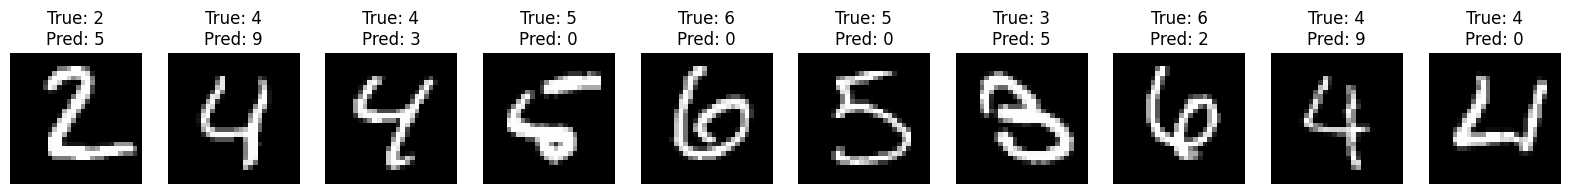

In [23]:
def analyze_misclassifications(test_images, test_labels):
    misclassified_images = []
    misclassified_labels = []
    predicted_labels = []

    for im, label in zip(test_images, test_labels):
        im_reshaped = im.reshape(1, 784)
        out_p, _, _ = nn_forward_prop(im_reshaped, label)
        predicted_label = np.argmax(out_p)

        if predicted_label != label:
            misclassified_images.append(im)
            misclassified_labels.append(label)
            predicted_labels.append(predicted_label)

    return misclassified_images, misclassified_labels, predicted_labels


misclassified_images, misclassified_labels, predicted_labels = analyze_misclassifications(test_images, test_labels)

def plot_misclassifications(misclassified_images, misclassified_labels, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[i].imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'True: {misclassified_labels[i]}\nPred: {predicted_labels[i]}')
        axes[i].axis('off')


plot_misclassifications(misclassified_images, misclassified_labels, predicted_labels, num_images=10)

### Confusion matrix

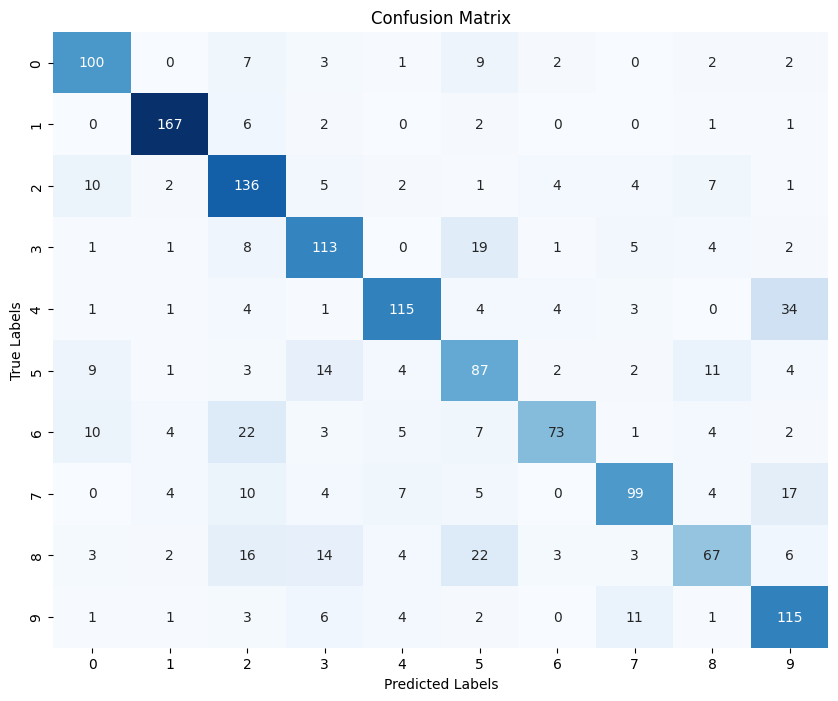

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_images, test_labels):
    predicted_labels = []

    for im, label in zip(test_images, test_labels):
        im_reshaped = im.reshape(1, 784)
        out_p = nn_forward_prop(im_reshaped, label)[0]
        predicted_label = np.argmax(out_p)
        predicted_labels.append(predicted_label)

    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_images, test_labels)


# Imporving the model

### 1. Change of activation function on relu

In [25]:
def relu(x):
    return x*(x>0).astype("float32")

def relu_der(x):
    return (x > 0).astype('float32')

In [26]:
class ReLU:
    def __init__(self, n_inputs, n_neurons, activation='relu'):
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2 / n_inputs)
        self.biases = np.zeros((1, n_neurons))
        self.activation = activation
    
    def forward_prop(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.biases
        if self.activation == 'relu':
            self.output = relu(self.z)
        elif self.activation == 'sigmoid':
            self.output = sigmoid(self.z)
        return self.output
    
    def back_prop(self, dvalues, learning_rate):
        if self.activation == 'relu':
            self.dactivation = relu_der(self.z)
        elif self.activation == 'sigmoid':
            self.dactivation = sigmoid_der(self.z)
        self.dvalues = dvalues * self.dactivation
        self.dweights = np.dot(self.inputs.T, self.dvalues)
        self.dbiases = np.sum(self.dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(self.dvalues, self.weights.T)
        self.weights -= learning_rate * self.dweights
        self.biases -= learning_rate * self.dbiases
        return self.dinputs

In [27]:
ReLU_LAYER1 = ReLU(784, 128, activation='relu')
ReLU_LAYER2 = ReLU(128, 64, activation='relu')
SOFTMAX_LAYER = Softmax(64, 10)

In [28]:
def nn_forward_prop(image, label):
  out_p = ReLU_LAYER1.forward_prop(image)
  out_p = ReLU_LAYER2.forward_prop(out_p)
  out_p = SOFTMAX_LAYER.forward_prop(out_p)

  cross_ent_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_ent_loss, accuracy_eval

def training_nn(image, label, learn_rate =0.005):
  out, loss, acc = nn_forward_prop(image, label)

  #calculate ininital gradient
  gradient = np.zeros(10)
  #pochodna z funkcji kosztu cross-entropy
  #out[label] - odpowiedz neuronu ktory mial rozpoznac cyferke
  gradient[label] = -1 / out[label]

  #BACKPROP
  grad_back = SOFTMAX_LAYER.back_prop(gradient, learn_rate)
  grad_back = ReLU_LAYER2.back_prop(grad_back, learn_rate)
  grad_back = ReLU_LAYER1.back_prop(grad_back, learn_rate)

  return loss, acc

### Train and evaluate the model

In [29]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_and_evaluate(train_images, train_labels, val_images, val_labels, epochs=10, learning_rate=0.005)

Epoch 1 ->
100 steps out of 100 steps: Average Loss 2.319 and Accuracy: 14%
200 steps out of 100 steps: Average Loss 2.256 and Accuracy: 20%
300 steps out of 100 steps: Average Loss 2.217 and Accuracy: 14%
400 steps out of 100 steps: Average Loss 2.218 and Accuracy: 11%
500 steps out of 100 steps: Average Loss 2.131 and Accuracy: 20%
600 steps out of 100 steps: Average Loss 2.084 and Accuracy: 33%
700 steps out of 100 steps: Average Loss 1.970 and Accuracy: 48%
800 steps out of 100 steps: Average Loss 1.838 and Accuracy: 49%
900 steps out of 100 steps: Average Loss 1.545 and Accuracy: 61%
1000 steps out of 100 steps: Average Loss 1.547 and Accuracy: 53%
1100 steps out of 100 steps: Average Loss 1.343 and Accuracy: 61%
1200 steps out of 100 steps: Average Loss 1.132 and Accuracy: 70%
1300 steps out of 100 steps: Average Loss 0.997 and Accuracy: 67%
1400 steps out of 100 steps: Average Loss 1.119 and Accuracy: 67%
Validation Loss: 0.882 and Validation Accuracy: 77%
Epoch 2 ->
100 steps o

### Plot training and validation accuracy

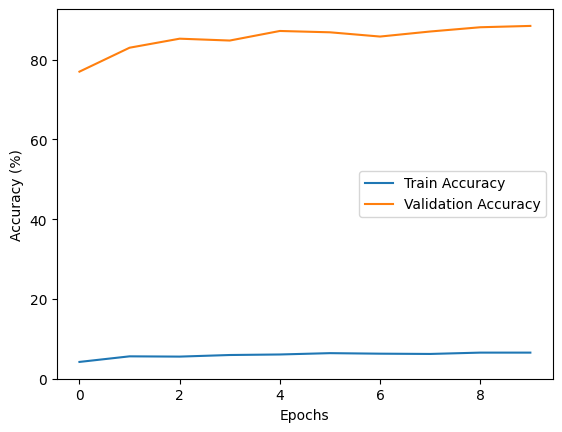

In [30]:
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot training and validation loss

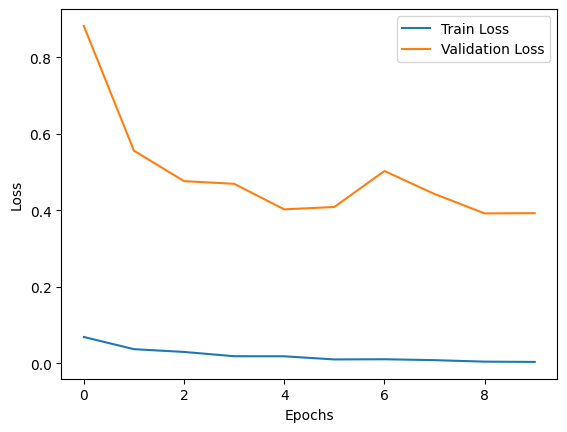

In [31]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing neural network

In [32]:
def test_nn(test_images, test_labels):
    test_loss = 0
    test_num_correct = 0

    for im, label in zip(test_images, test_labels):
        im = im.reshape(1, 784)
        _, l1, accu = nn_forward_prop(im, label)
        test_loss += l1
        test_num_correct += accu

    test_loss /= len(test_images)
    test_accuracy = test_num_correct / len(test_images) * 100

    print('Test Loss: %.3f' % test_loss)
    print('Test Accuracy: %d%%' % test_accuracy)

    return test_loss, test_accuracy

test_loss, test_accuracy = test_nn(test_images, test_labels)

Test Loss: 0.416
Test Accuracy: 87%


### What digits the algorithm has a problem with and what errors it makes when recognizing them.

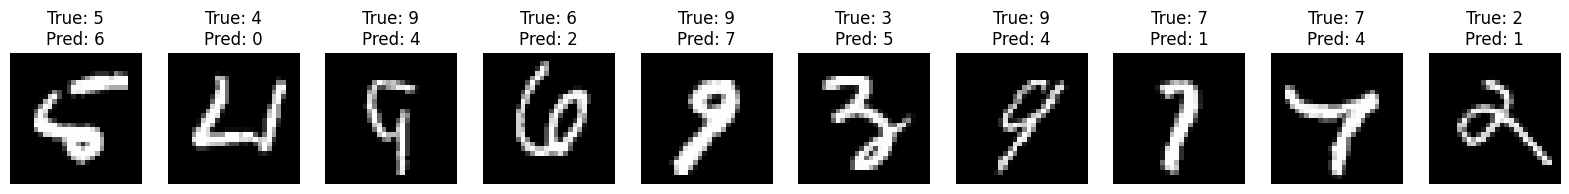

In [33]:
def analyze_misclassifications(test_images, test_labels):
    misclassified_images = []
    misclassified_labels = []
    predicted_labels = []

    for im, label in zip(test_images, test_labels):
        im_reshaped = im.reshape(1, 784)
        out_p, _, _ = nn_forward_prop(im_reshaped, label)
        predicted_label = np.argmax(out_p)

        if predicted_label != label:
            misclassified_images.append(im)
            misclassified_labels.append(label)
            predicted_labels.append(predicted_label)

    return misclassified_images, misclassified_labels, predicted_labels


misclassified_images, misclassified_labels, predicted_labels = analyze_misclassifications(test_images, test_labels)

def plot_misclassifications(misclassified_images, misclassified_labels, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[i].imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'True: {misclassified_labels[i]}\nPred: {predicted_labels[i]}')
        axes[i].axis('off')


plot_misclassifications(misclassified_images, misclassified_labels, predicted_labels, num_images=10)

### Confusion matrix

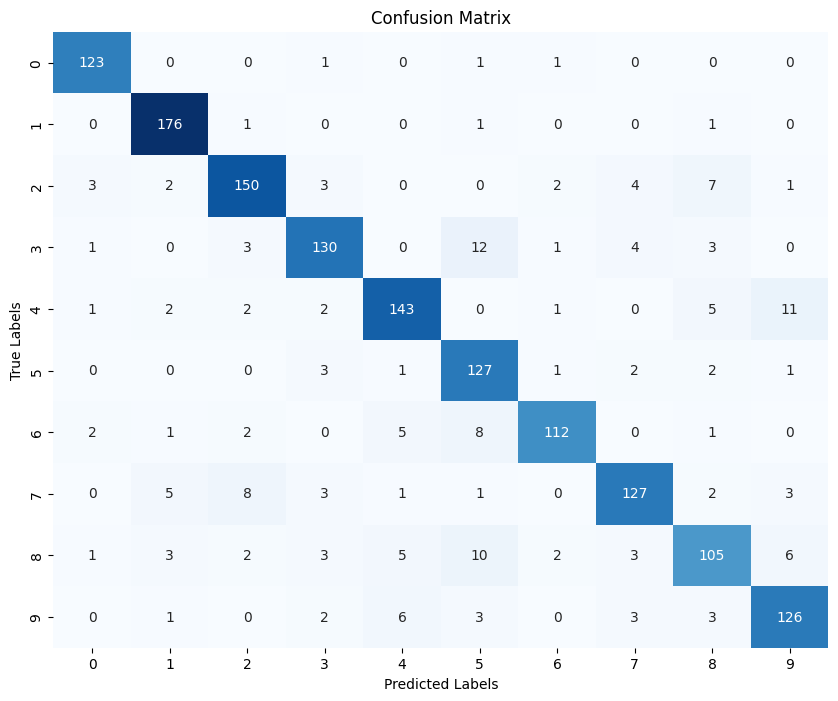

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_images, test_labels):
    predicted_labels = []

    for im, label in zip(test_images, test_labels):
        im_reshaped = im.reshape(1, 784)
        out_p = nn_forward_prop(im_reshaped, label)[0]
        predicted_label = np.argmax(out_p)
        predicted_labels.append(predicted_label)

    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_images, test_labels)

### 2. Adding Dropout Layers

In [37]:
class Dropout:
    def __init__(self, dropout_rate):
        self.rate = dropout_rate
        self.mask = None

    def forward_prop(self, input_data, training=True):
        if training:
            self.mask = (np.random.rand(*input_data.shape) > self.rate) / (1.0 - self.rate)
            return input_data * self.mask
        else:
            return input_data

    def back_prop(self, gradient, learning_rate):
        return gradient * self.mask

In [38]:
DROPOUT_LAYER1 = Dropout(0.2)  # 20% dropout rate
DROPOUT_LAYER2 = Dropout(0.2)

In [39]:
def nn_forward_prop(image, label, training=True):
    out_p = ReLU_LAYER1.forward_prop(image)
    out_p = DROPOUT_LAYER1.forward_prop(out_p, training)
    out_p = ReLU_LAYER2.forward_prop(out_p)
    out_p = DROPOUT_LAYER2.forward_prop(out_p, training)
    out_p = SOFTMAX_LAYER.forward_prop(out_p)

    cross_ent_loss = -np.log(out_p[label])
    accuracy_eval = 1 if np.argmax(out_p) == label else 0

    return out_p, cross_ent_loss, accuracy_eval

def training_nn(image, label, learn_rate=0.005):
    out, loss, acc = nn_forward_prop(image, label, training=True)

    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    grad_back = SOFTMAX_LAYER.back_prop(gradient, learn_rate)
    grad_back = DROPOUT_LAYER2.back_prop(grad_back, learn_rate)
    grad_back = ReLU_LAYER2.back_prop(grad_back, learn_rate)
    grad_back = DROPOUT_LAYER1.back_prop(grad_back, learn_rate)
    grad_back = ReLU_LAYER1.back_prop(grad_back, learn_rate)

    return loss, acc

### Train and evaluate the model

In [40]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_and_evaluate(train_images, train_labels, val_images, val_labels, epochs=10, learning_rate=0.005)

Epoch 1 ->
100 steps out of 100 steps: Average Loss 0.441 and Accuracy: 87%
200 steps out of 100 steps: Average Loss 0.349 and Accuracy: 86%
300 steps out of 100 steps: Average Loss 0.516 and Accuracy: 79%
400 steps out of 100 steps: Average Loss 0.292 and Accuracy: 92%
500 steps out of 100 steps: Average Loss 0.256 and Accuracy: 90%
600 steps out of 100 steps: Average Loss 0.194 and Accuracy: 94%
700 steps out of 100 steps: Average Loss 0.324 and Accuracy: 90%
800 steps out of 100 steps: Average Loss 0.342 and Accuracy: 87%
900 steps out of 100 steps: Average Loss 0.253 and Accuracy: 91%
1000 steps out of 100 steps: Average Loss 0.225 and Accuracy: 94%
1100 steps out of 100 steps: Average Loss 0.385 and Accuracy: 85%
1200 steps out of 100 steps: Average Loss 0.296 and Accuracy: 92%
1300 steps out of 100 steps: Average Loss 0.244 and Accuracy: 91%
1400 steps out of 100 steps: Average Loss 0.328 and Accuracy: 89%
Validation Loss: 0.605 and Validation Accuracy: 81%
Epoch 2 ->
100 steps o

### Plot training and validation accuracy

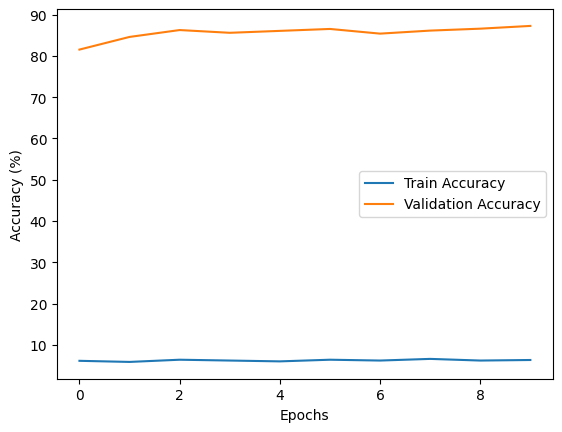

In [41]:
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

### Plot training and validation loss

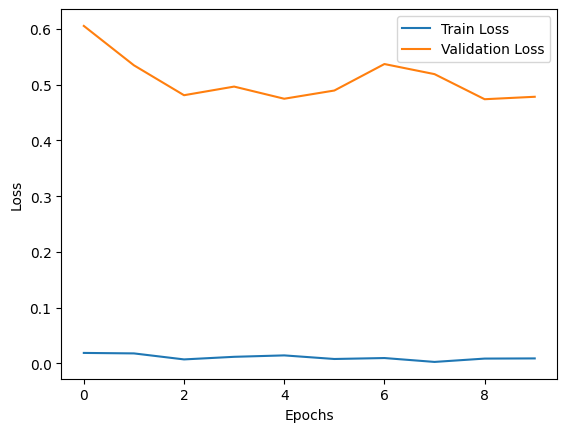

In [42]:
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing neural network

In [43]:
def test_nn(test_images, test_labels):
    test_loss = 0
    test_num_correct = 0

    for im, label in zip(test_images, test_labels):
        im = im.reshape(1, 784)
        _, l1, accu = nn_forward_prop(im, label)
        test_loss += l1
        test_num_correct += accu

    test_loss /= len(test_images)
    test_accuracy = test_num_correct / len(test_images) * 100

    print('Test Loss: %.3f' % test_loss)
    print('Test Accuracy: %d%%' % test_accuracy)

    return test_loss, test_accuracy

test_loss, test_accuracy = test_nn(test_images, test_labels)

Test Loss: 0.537
Test Accuracy: 86%


### What digits the algorithm has a problem with and what errors it makes when recognizing them.

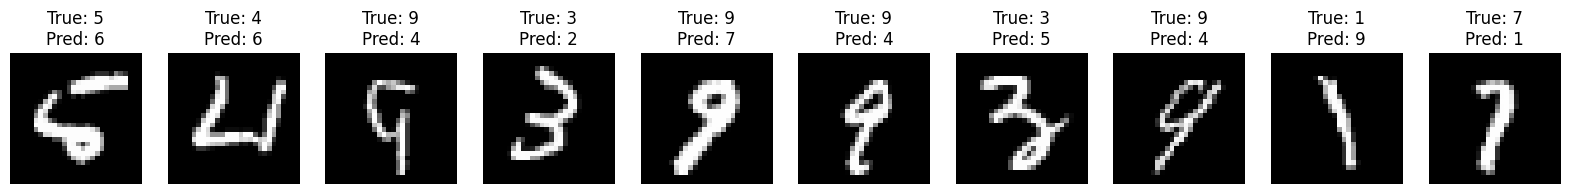

In [44]:
def analyze_misclassifications(test_images, test_labels):
    misclassified_images = []
    misclassified_labels = []
    predicted_labels = []

    for im, label in zip(test_images, test_labels):
        im_reshaped = im.reshape(1, 784)
        out_p, _, _ = nn_forward_prop(im_reshaped, label)
        predicted_label = np.argmax(out_p)

        if predicted_label != label:
            misclassified_images.append(im)
            misclassified_labels.append(label)
            predicted_labels.append(predicted_label)

    return misclassified_images, misclassified_labels, predicted_labels


misclassified_images, misclassified_labels, predicted_labels = analyze_misclassifications(test_images, test_labels)

def plot_misclassifications(misclassified_images, misclassified_labels, predicted_labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[i].imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'True: {misclassified_labels[i]}\nPred: {predicted_labels[i]}')
        axes[i].axis('off')


plot_misclassifications(misclassified_images, misclassified_labels, predicted_labels, num_images=10)

### Confusion matrix

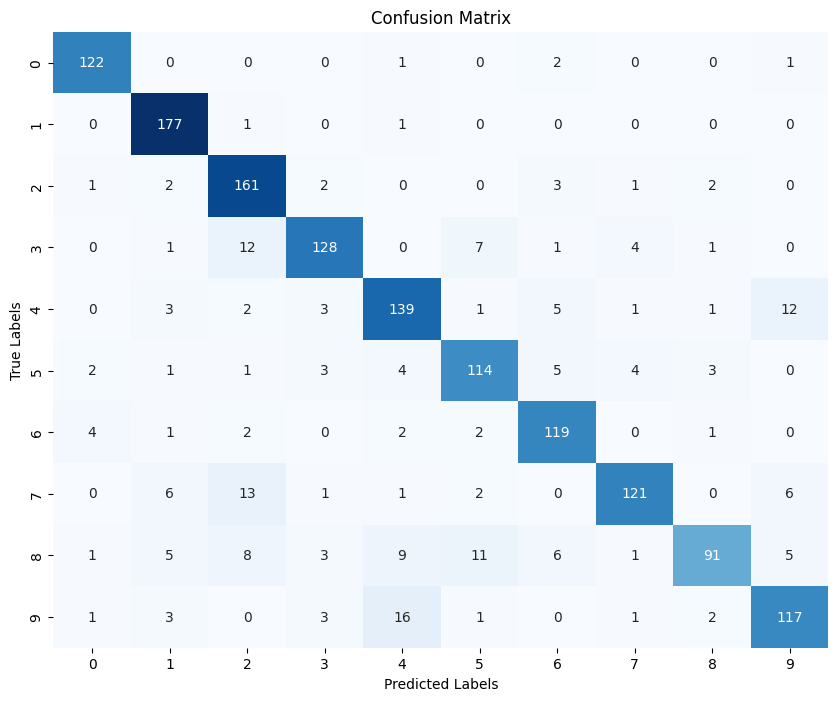

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_images, test_labels):
    predicted_labels = []

    for im, label in zip(test_images, test_labels):
        im_reshaped = im.reshape(1, 784)
        out_p = nn_forward_prop(im_reshaped, label)[0]
        predicted_label = np.argmax(out_p)
        predicted_labels.append(predicted_label)

    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_images, test_labels)